# Alcoholism Classification using Efficient Deep Convolutional Neural Networks 

Binary classification for EEG- alcoholism dataset using Convolutional Neural Networks.


The following notebook was run on Colab due to unavailability of good RAM and GPU locally. Initially I built and tested it on my system but the training time for even the base model was huge so I shifted to using Colab and ultimately Colab Pro.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)



Mounted at /content/gdrive


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import scipy.io
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib.pyplot import imshow
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn as nn
from torchvision import datasets, transforms, models
import torch.optim as optim
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from sklearn.utils import resample

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load and setup training dataset:

In [ ]:
# load all data
#  when using colab
#mat = scipy.io.loadmat('/content/gdrive/MyDrive/uci_eeg_images.mat')

# Uncomment the line below, if using colab and loading the file from drive
mat = scipy.io.loadmat('uci_eeg_images.mat')
print(mat.keys())
data = mat['data']
labels = mat['y_alcoholic']

#subjectid is not relevant to the cassification task.
subject_id = mat['subjectid']
ystimulus = mat['y_stimulus']


dict_keys(['__header__', '__version__', '__globals__', 'data', 'y_alcoholic', 'y_stimulus', 'subjectid'])


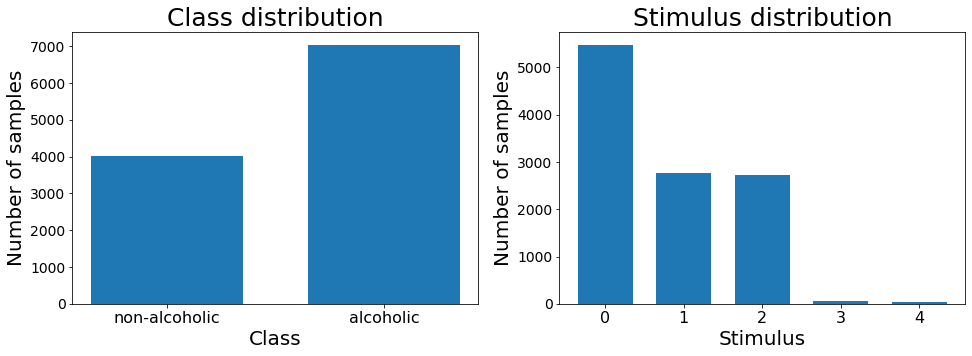

In [ ]:
# stimulus distribution
stim = list( pd.DataFrame(ystimulus.T).value_counts())


# Class distribution
x = list( pd.DataFrame(labels.T).value_counts())
# because value counts returns in descending order of occurences. and alcoholic is more in number
x.reverse()
#print(x)
#plot 
fig=plt.figure(figsize=(16, 5))

fig.add_subplot(1,2,1)
plt.bar(np.arange(len(x)),x, width = 0.7)
plt.xticks([0, 1],['non-alcoholic','alcoholic'])
plt.xlabel('Class', fontsize = 20)
plt.ylabel('Number of samples', fontsize = 20)
plt.title('Class distribution',  fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)

fig.add_subplot(1,2,2)
plt.bar(np.arange(len(stim)),stim, width = 0.7)
plt.xlabel('Stimulus', fontsize = 20)
plt.ylabel('Number of samples', fontsize = 20)
plt.title('Stimulus distribution',  fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.savefig("stimulus.png")

plt.show()

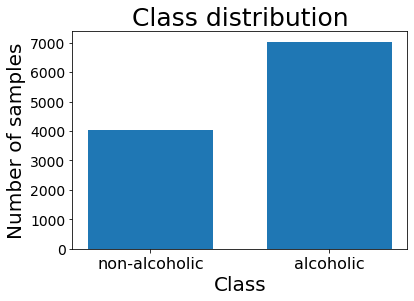

In [ ]:
# Class distribution
x = list( pd.DataFrame(labels.T).value_counts())
# because value counts returns in descending order of occurences. and alcoholic is more in number
x.reverse()
#print(x)
#plot 
plt.bar(np.arange(len(x)),x, width = 0.7)
plt.xticks([0, 1],['non-alcoholic','alcoholic'])

plt.xlabel('Class', fontsize = 20)
plt.ylabel('Number of samples', fontsize = 20)
plt.title('Class distribution',  fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.savefig("classdist1.png")

plt.show()


Minimum pixel value  -1.8584307499490746
Maximum pixel value  18.55155066186601


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


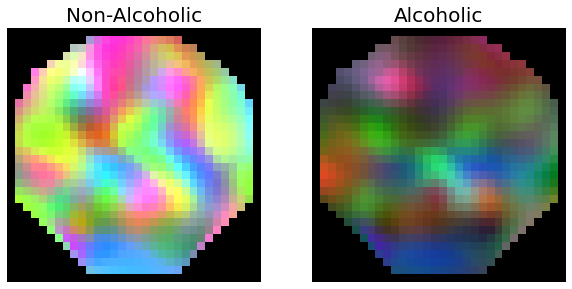

In [ ]:
# Visualizing data
print("Minimum pixel value ", np.min(data))
print("Maximum pixel value ",np.max(data))
lb = labels.T
non_alc_sample = data[np.nonzero(lb == 0)[0]][20]
alc_sample = data[np.nonzero(lb == 1)[0]][20]

fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.title("Non-Alcoholic",  fontsize = 20)
plt.axis('off')
plt.imshow(non_alc_sample)
fig.add_subplot(1,2,2)
plt.title("Alcoholic",  fontsize = 20)
plt.imshow(alc_sample)
plt.axis('off')
plt.savefig('eeg1.png')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


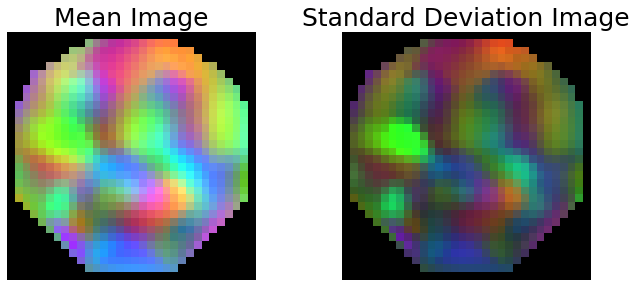

In [ ]:
# Visualizing mean and standard deviation image
mean_img = np.mean(data, axis = 0)
std_img = np.std(data, axis =0)
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.title("Mean Image", fontsize = 25)
plt.axis('off')
plt.imshow(mean_img)
fig.add_subplot(1,2,2)
plt.title("Standard Deviation Image", fontsize = 25)
plt.imshow(std_img)
plt.axis('off')
fig.tight_layout(pad=5.0)
plt.savefig("eeg3.png")
plt.show()

#### Normalizing the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Minimum pixel value after normalization -4.745074811342956
Maximum pixel value after normalization 36.933964585043604


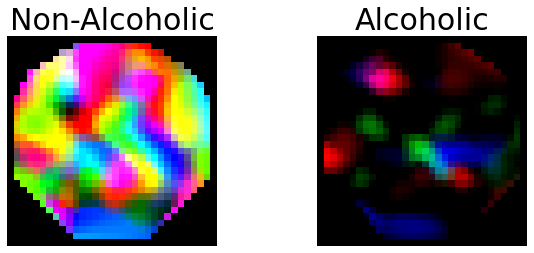

In [ ]:
# normalizing data using StandardScaler
data_n = data
scaler =  StandardScaler()
data_n = scaler.fit_transform(data_n.reshape(-1, data_n.shape[-1])).reshape(data_n.shape)
print("Minimum pixel value after normalization", np.min(data_n))
print("Maximum pixel value after normalization",np.max(data_n))

lb = labels.T
non_alc_sample = data_n[np.nonzero(lb == 0)[0]][20]
alc_sample = data_n[np.nonzero(lb == 1)[0]][20]

fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.title("Non-Alcoholic",  fontsize = 30)
plt.axis('off')
plt.imshow(non_alc_sample)
fig.add_subplot(1,2,2)
plt.title("Alcoholic",  fontsize = 30)
plt.axis('off')
plt.imshow(alc_sample)
fig.tight_layout(pad=10.0)
plt.savefig("eeg2.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


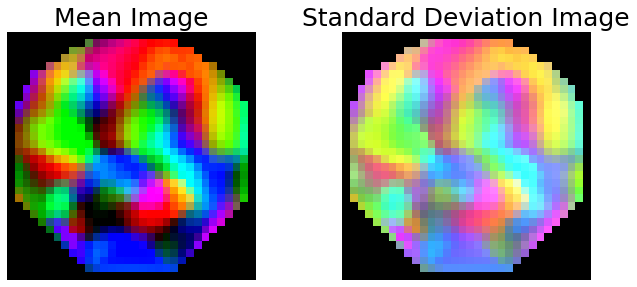

In [ ]:
# visualizing mean and std after normalizing
mean_img = np.mean(data_n, axis = 0)
std_img = np.std(data_n, axis =0)
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.title("Mean Image", fontsize = 25)
plt.axis('off')
plt.imshow(mean_img)
fig.add_subplot(1,2,2)
plt.title("Standard Deviation Image", fontsize = 25)
plt.axis('off')
plt.imshow(std_img)
fig.tight_layout(pad=5.0)
plt.savefig("eeg4.png")
plt.show()

### Fixing Class imbalance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


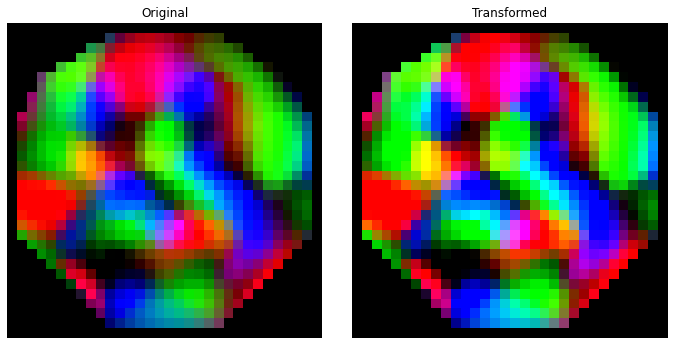

In [ ]:
# Separate majority and minority classes

lb = labels.T
#alc = data_n[np.nonzero(lb == 1)[0]]
#print(alc.shape)

non_alc = data_n[np.nonzero(lb == 0)[0]]
#print(non_alc.shape)

random_indices = np.random.choice(non_alc.shape[0], size=3000, replace=False)
random_indices.sort(kind = "mergesort")
tst = non_alc[random_indices[0]]

# select 3000 images randomly to appy transofrms on
non_alc_t = torch.Tensor(non_alc[random_indices]).float()
#reshape the tensor
non_alc_t = non_alc_t.permute(0,3,1,2)
#select transforms
trans = transforms.ColorJitter(brightness=0.2, contrast=0.6, saturation=0, hue=0)
#new generated/transormed data
trans_data = trans(non_alc_t).permute(0,2,3,1)

fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1)
plt.title("Original")
plt.axis('off')
plt.imshow(tst)
fig.add_subplot(1,2,2)
plt.title("Transformed")
plt.axis('off')
plt.imshow(trans_data[0])
fig.tight_layout(pad=3.0)
plt.show()



In [ ]:
# adding new data into old
new_data = np.concatenate((data_n, trans_data.numpy()), axis=0)
print(new_data.shape)
new_labels = np.concatenate((labels, np.zeros((1,3000))), axis=1)
print(new_labels.shape)
# shuffling data to keep randomness
data_b, labels_b = shuffle(new_data, new_labels.T, random_state = 1)
print(data_b.shape)
print(labels_b.shape)

(14057, 32, 32, 3)
(1, 14057)
(14057, 32, 32, 3)
(14057, 1)


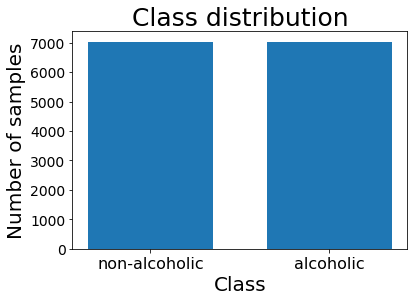

In [ ]:
# visualizing distribution after fixing imbalance
x = list( pd.DataFrame(labels_b).value_counts())
# because value counts returns in descending order of occurences. and alcoholic is more in number
x.reverse()
#print(x)
#plot 
plt.bar(np.arange(len(x)),x, width = 0.7)
plt.xticks([0, 1],['non-alcoholic','alcoholic'])
plt.xlabel('Class', fontsize = 20)
plt.ylabel('Number of samples', fontsize = 20)
plt.title('Class distribution',  fontsize = 25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.savefig("classdist2.png")

plt.show()


In [ ]:
# function to convert numy data and labels to a TensorDataset
def data_to_dataset(data, labels):
  #print(data.shape)

  data = torch.Tensor(data).float()
  label = torch.Tensor(labels).type(torch.LongTensor)
  label = torch.reshape(label, (-1,))
  data = data.permute(0,3,1,2)
  #print(label.shape)
  #print(data.shape)
  dataset = TensorDataset(data, label)
  return dataset

In [ ]:
# generating train test and validation loaders from the TensorDataset
def ds_to_dl(batch_size,dataset):
  train_size = int(0.7* len(dataset))
  # first will split into train and val_test 70:30
  val_test_size = int(len(dataset) - train_size)
  # then split the val_test in half therfore having an overall 70:15:15
  val_size = int(0.5 * val_test_size)
  test_size = val_test_size - val_size

  train_data, val_test_data = random_split(dataset,[train_size,val_test_size])
  test_data, val_data = random_split(val_test_data,[test_size,val_size])

  #print(f"Length of Train Data : {len(train_data)}")
  #print(f"Length of Validation Data : {len(val_data)}")
  #print(f"Length of Test Data : {len(test_data)}")
  
  #load the train and validation into batches.
  train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
  val_dl = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)
  test_dl = DataLoader(train_data, batch_size*2, num_workers = 2, pin_memory = True)
  
  return train_dl, val_dl, test_dl

In [ ]:
# function to visualize the batch data
def show_batch(dl):
    #Plot images grid of single batch
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [ ]:
## Train, test and validate functions are majorly inspired from Lab4 CNN code
def train(model, epoch):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
      
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        loss.backward()
        optimizer.step()
        if 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc
    

def validate(model):
    model.eval()
    val_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        val_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    val_loss /= len(val_loader.dataset)
    val_acc = 100. * correct / len(val_loader.dataset)

    return val_loss, val_acc
    

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(test_loss, test_acc))


In [ ]:
# functions for plotting accuracues and losses
def plot_acc(all_train_acc, all_val_acc):
  epochs = len(all_train_acc)
  #print(epochs)
  fig, ax = plt.subplots(figsize = (6,4))
  dim = np.arange(1, epochs+1)
  ax.plot(dim,all_train_acc, '-g', label = 'Training Accuracy')
  ax.plot(dim, all_val_acc, '--r', label = 'Validation Accuracy')
  leg = ax.legend(prop={'size': 14});
  ax.set_title("Accuracies", fontsize = 20)
  ax.set_xlabel("Epochs", fontsize = 16)
  ax.set_ylabel("Accuracy", fontsize = 16)
  ax.set_xlim([1,epochs+1])
  ax.set_ylim([0,105])
  y = np.arange(0, 110, 10)
  ax.set_xticks(np.arange(0, epochs+1, 2))
  ax.set_yticks(y)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=14)
  plt.grid()
  plt.savefig("m3acc.png")
  plt.show()

def plot_loss(all_train_loss, all_val_loss):
  epochs = len(all_train_loss)
  fig, ax = plt.subplots(figsize = (6,4))
  dim = np.arange(1, epochs+1)
  ax.plot(dim,all_train_loss, '-g', label = 'Training Loss')
  ax.plot(dim, all_val_loss, '--r', label = 'Validation Loss')
  leg = ax.legend(prop={'size': 14});
  plt.title("Loss", fontsize = 20)
  plt.xlabel("Epochs", fontsize = 16)
  plt.ylabel("Loss", fontsize = 16)
  ax.set_xlim([1,epochs+1])
  ax.set_ylim([0,1])
  ax.set_xticks(np.arange(0, epochs+1,2))
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=14)
  plt.grid()
  plt.savefig("m3loss.png")
  plt.show()


# Running Base model

In [ ]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


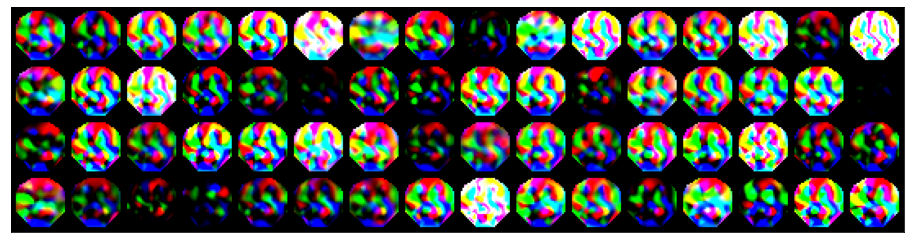

In [ ]:
batch_size = 64
# creating dataset with balanced data, for original data use (data, labels); for normalised use (data_n, labels) 
# and (data_b, labels_b) for normalized and balanced dataset
dataset = data_to_dataset(data_b,labels_b)
train_loader, val_loader, test_loader = ds_to_dl(batch_size,dataset)
show_batch(train_loader)

In [ ]:
#initialise base model
base_model = BaseNet()
#print(model)
base_model.cuda()
optimizer = optim.SGD(base_model.parameters(), lr=0.01)

Epoch 1, Training loss:0.6747, Training Accuracy:63% | Validation loss:0.6383, Validation Accuracy:76%
Epoch 3, Training loss:0.5652, Training Accuracy:75% | Validation loss:0.5290, Validation Accuracy:76%
Epoch 6, Training loss:0.5034, Training Accuracy:76% | Validation loss:0.4767, Validation Accuracy:77%
Epoch 9, Training loss:0.4686, Training Accuracy:77% | Validation loss:0.4773, Validation Accuracy:77%
Epoch 12, Training loss:0.4532, Training Accuracy:78% | Validation loss:0.4479, Validation Accuracy:77%
Epoch 15, Training loss:0.4424, Training Accuracy:78% | Validation loss:0.4293, Validation Accuracy:78%
Epoch 18, Training loss:0.4323, Training Accuracy:79% | Validation loss:0.4241, Validation Accuracy:79%
Epoch 21, Training loss:0.4247, Training Accuracy:79% | Validation loss:0.4245, Validation Accuracy:79%
Epoch 24, Training loss:0.4145, Training Accuracy:80% | Validation loss:0.4131, Validation Accuracy:79%
Epoch 27, Training loss:0.4114, Training Accuracy:80% | Validation l

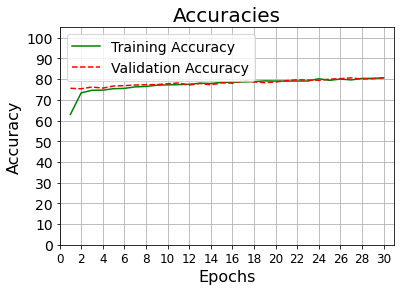

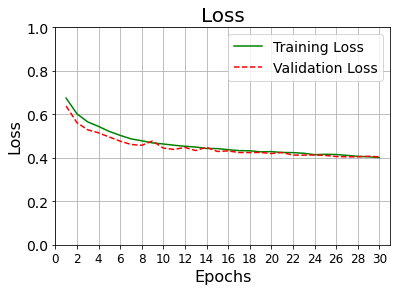


Test set: Average loss: 0.3891, Accuracy: (81%)



In [ ]:
#### TRAIN #####
epochs = 30
val_loss_all = []
train_loss_all = []
val_acc_all = []
train_acc_all = []
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(base_model, epoch)
    train_loss_all.append(train_loss)
    train_acc_all.append(train_acc)

    val_loss, val_acc = validate(base_model)
    val_loss_all.append(val_loss)
    val_acc_all.append(val_acc)
    if epoch == 1 or epoch % 3== 0:
      print('Epoch {}, Training loss:{:.4f}, Training Accuracy:{:.0f}% | Validation loss:{:.4f}, Validation Accuracy:{:.0f}%'.format(epoch,train_loss, train_acc, val_loss, val_acc))
    
plot_acc(train_acc_all, val_acc_all)
plot_loss(train_loss_all, val_loss_all)

test(base_model)

##Model 2 and 3

Both model M2 and M3 were tested within the network below. Model 2 had just 3 Conv blocks and model 3 had the additional 4th block, The only change this caued was in the number of features inputted in the first fully connected layer which was 4096 in case of model 2(M2) and is 2048 incase of model 3(M3)

In [ ]:
# This is not an implementation of some specific DeepNet model like http://www.cs.toronto.edu/~nitish/deepnet/ and many more.
# This is a different implementation done by trying ot different combinations by me.   
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()        
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.3),

            ############ Comment this Conv 4 block for model 2/ M2, and keep it uncommented for for model 3(M3)
            # Conv Layer block 4
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.3),
            # uncomment the below layer for model 2 and comment the next one
            #nn.Linear(4096, 1024, bias=True),
            nn.Linear(2048, 1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        #print(x.shape)
        # fc layer
        x = self.fc_layer(x)
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
batch_size = 64
dataset = data_to_dataset(data_b,labels_b)
train_loader, val_loader, test_loader = ds_to_dl(batch_size,dataset)
#print(len(dataset))
#show_batch(train_loader)

In [ ]:
#initialise model
deep_model = DeepNet()
#print(model)
deep_model.cuda()
optimizer = optim.SGD(deep_model.parameters(), lr=0.01)

Epoch 1, Training loss:0.6888, Training Accuracy:54% | Validation loss:0.6744, Validation Accuracy:64%
Epoch 3, Training loss:0.4838, Training Accuracy:75% | Validation loss:0.4598, Validation Accuracy:76%
Epoch 6, Training loss:0.4476, Training Accuracy:78% | Validation loss:0.4326, Validation Accuracy:79%
Epoch 9, Training loss:0.4162, Training Accuracy:80% | Validation loss:0.4086, Validation Accuracy:80%
Epoch 12, Training loss:0.3824, Training Accuracy:82% | Validation loss:0.3768, Validation Accuracy:82%
Epoch 15, Training loss:0.3365, Training Accuracy:85% | Validation loss:0.4214, Validation Accuracy:82%
Epoch 18, Training loss:0.3037, Training Accuracy:87% | Validation loss:0.3502, Validation Accuracy:84%
Epoch 21, Training loss:0.2682, Training Accuracy:88% | Validation loss:0.3034, Validation Accuracy:87%
Epoch 24, Training loss:0.2407, Training Accuracy:90% | Validation loss:0.3192, Validation Accuracy:87%
Epoch 27, Training loss:0.2002, Training Accuracy:92% | Validation l

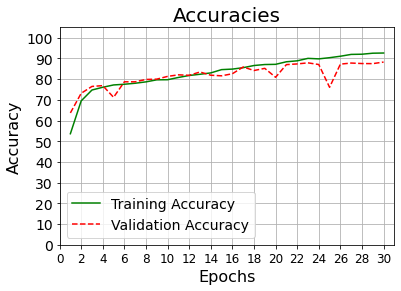

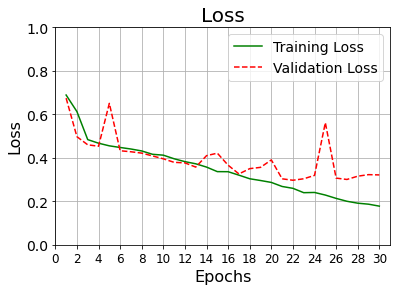


Test set: Average loss: 0.1235, Accuracy: (95%)



In [ ]:
############### TRAIN ########
epochs = 30
val_loss_all = []
train_loss_all = []
val_acc_all = []
train_acc_all = []
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(deep_model, epoch)
    train_loss_all.append(train_loss)
    train_acc_all.append(train_acc)

    val_loss, val_acc = validate(deep_model)
    val_loss_all.append(val_loss)
    val_acc_all.append(val_acc)
    if epoch ==1 or epoch% 3 == 0:
      print('Epoch {}, Training loss:{:.4f}, Training Accuracy:{:.0f}% | Validation loss:{:.4f}, Validation Accuracy:{:.0f}%'.format(epoch,train_loss, train_acc, val_loss, val_acc))
    
plot_acc(train_acc_all, val_acc_all)
plot_loss(train_loss_all, val_loss_all)

test(deep_model)